In [1]:
%cd ~/bench

/home/soda/rcappuzz/work/benchmark-join-suggestions


In [3]:
%load_ext autoreload
%autoreload 2
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import matplotlib.colors as mcolors
import matplotlib as mpl
import src.utils.plotting as plotting
import src.utils.constants as constants
from src.utils.logging import read_logs
from matplotlib.gridspec import GridSpec
import polars.selectors as cs

import tarfile
import json
import pandas as pd 
cfg = pl.Config()
cfg.set_fmt_str_lengths(150)
LABEL_MAPPING = constants.LABEL_MAPPING

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
sns.set_context("talk")
plt.style.use("seaborn-v0_8-talk")

In [5]:
mapping_times = {
    "time_join_predict": "Predict(join)",
    "time_model_predict": "Predict(model)",
    "time_join_train": "Train(join)",
    "time_model_train": "Train(model)",
    "time_prepare": "Prepare",
}

In [6]:
# full run, aggr. first
# df_1 = read_logs(exp_name="0354-m76sawxd", exp_path=None)
# # full run, aggr. mean
# df_2 = read_logs(exp_name="0348-1bne8cxm", exp_path=None)
# df_raw = pl.concat([df_1, df_2]).fill_null(0)

In [7]:
# exp_name = "0360-jinwugcl"
exp_path = "results/logs/0363-mp1a3by4"
df_raw = read_logs(exp_name=None, exp_path=exp_path)
df_raw = df_raw.fill_null(0)

In [8]:
def prepare_relative_times(df, grouping_variable):
    f = (
        df.group_by(grouping_variable)
        .agg(
            pl.col("time_prepare").mean(),
            pl.col("time_model_train").mean(),
            pl.col("time_join_train").mean(),
            pl.col("time_model_predict").mean(),
            pl.col("time_join_predict").mean(),
        )
        .with_columns(pl.sum_horizontal(cs.numeric()).alias("total"))
        .with_columns(cs.starts_with("time_") / pl.col("total"))
        .sort("total")
        .drop("total")
        .melt(id_vars=grouping_variable)
    )
    return f

In [9]:
def prepare_absolute_times(df, grouping_variable):
    f = (
        df.group_by(grouping_variable)
        .agg(
            pl.col("time_prepare").mean(),
            pl.col("time_model_train").mean(),
            pl.col("time_join_train").mean(),
            pl.col("time_model_predict").mean(),
            pl.col("time_join_predict").mean(),
        )
        .with_columns(pl.sum_horizontal(cs.numeric()).alias("total"))
        .sort("total")
        .drop("total")
        .melt(id_vars=grouping_variable)
    )
    return f

In [10]:
def prepare_total_times(df, grouping_variable):
    f = (
        df.group_by(grouping_variable)
        .agg(
            pl.col("time_prepare").mean(),
            pl.col("time_model_train").mean(),
            pl.col("time_join_train").mean(),
            pl.col("time_model_predict").mean(),
            pl.col("time_join_predict").mean(),
        )
        .with_columns(pl.sum_horizontal(cs.numeric()).alias("total"))
        .drop(cs.starts_with("time_"))
        .melt(id_vars=grouping_variable)
    )
    return f

In [11]:
grouping_variable = "estimator"
results = (
    df_raw
    # df_raw.filter(pl.col("chosen_model") == chosen_model)
    .group_by(grouping_variable)
    .agg(
        # pl.col("time_fit").mean(),
        # pl.col("time_predict").mean(),
        # pl.col("time_run").mean(),
        pl.col("time_prepare").mean(),
        pl.col("time_model_train").mean(),
        pl.col("time_join_train").mean(),
        pl.col("time_model_predict").mean(),
        pl.col("time_join_predict").mean(),
    )
    .melt(id_vars=grouping_variable)
)

In [58]:
def prepare_subplot(df, ax, grouping_variable, variant: str = "absolute"):
    if variant == "absolute":
        results = prepare_absolute_times(df, grouping_variable)
        label = "Execution time (s)"
    elif variant == "relative":
        results = prepare_relative_times(df, grouping_variable)
        label = "Frac. spent in sections"
    elif variant == "total":
        results = prepare_total_times(df, grouping_variable)
        label = "Execution time (s)"
    else:
        raise NotImplementedError
    dicts = results.group_by([grouping_variable]).agg(pl.all()).sort(grouping_variable).to_dicts()

    to_concat = []
    for _, gr in results.sort(grouping_variable,descending=True).group_by([grouping_variable], maintain_order=True):
        new_g = (
            gr.sort("variable")
            .with_columns(pl.col("value").cum_sum().alias("csum"))
            .with_columns(
                pl.col("csum").alias("bottom").shift(1).fill_null(0),
            )
        )
        to_concat.append(new_g)
    df_c = pl.concat(to_concat)
    dicts = df_c.sort("variable",descending=True).group_by(["variable"], maintain_order=True).agg(pl.all()).to_dicts()

    y_ticks=[]
    y_tick_labels=[]

    for idx, d in enumerate(dicts):
        print(d["variable"])
        p = ax.barh(
            y=d[grouping_variable],
            width=d["value"],
            left=d["bottom"],
            label=d["variable"],
            tick_label=d[grouping_variable]
        )
        if variant == "total":
            ax.bar_label(p,fmt="{:.2f}", label_type="edge")
    ax.set_xlabel(label)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    y_ticks = ax.get_yticks()
    print(y_ticks)
    ax.set_yticks(y_ticks, [LABEL_MAPPING[grouping_variable][v] for v in d[grouping_variable]])
    

time_prepare
time_model_train
time_model_predict
time_join_train
time_join_predict
[0. 1. 2. 3. 4.]
total
[0. 1. 2. 3. 4.]


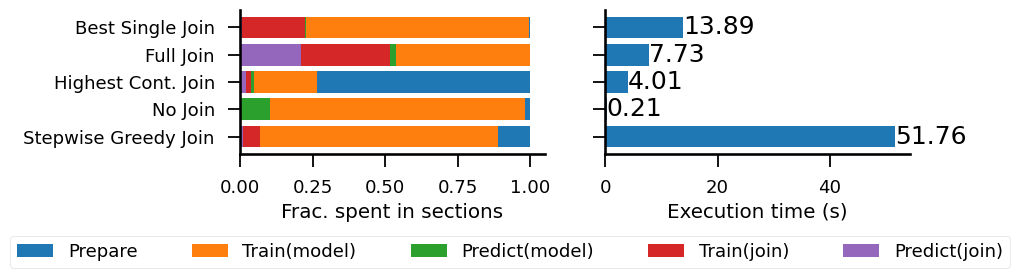

In [60]:
grouping_variable = "estimator"
fig, axs = plt.subplots(
    1, 2, 
    # layout="constrained", 
    sharey=True, 
    figsize=(10, 3),
)
# fig, axs = plt.subplots(1,2, layout="constrained", sharey=True, figsize=(8,2))
prepare_subplot(df_raw, axs[0], grouping_variable, "relative")
prepare_subplot(df_raw, axs[1], grouping_variable, "total")
# axs[2].axis("off")
h, l = axs[0].get_legend_handles_labels()
labels = [mapping_times[_] for _ in l]
fig.legend(h, labels, bbox_to_anchor=(0, 0.02, 1, 0.3), loc='lower left',
                      ncols=5, mode="expand", borderaxespad=0.)
plt.subplots_adjust(bottom=0.4)
plt.subplots_adjust(left=0.23)
fig.savefig(f"images/time_spent_{grouping_variable}.png")
fig.savefig(f"images/time_spent_{grouping_variable}.pdf")

In [53]:
grouping_variable = "jd_method"
results = prepare_relative_times(df_raw, grouping_variable)

to_concat = []
for _, gr in results.sort(grouping_variable).group_by(grouping_variable, maintain_order=True):
    new_g = (
        gr.sort("variable")
        .with_columns(pl.col("value").cumsum().alias("csum"))
        .with_columns(
            pl.col("csum").alias("bottom").shift(1).fill_null(0),
        )
    )
    to_concat.append(new_g)
df_c = pl.concat(to_concat)
dicts = df_c.group_by("variable").agg(pl.all()).sort("variable").to_dicts()
df_c.group_by("variable").agg(pl.all()).sort("variable")

/storage/workspace/tmp/ipykernel_44566/4105650199.py:5: DeprecationWarning: `group_by` iteration will change to always return group identifiers as tuples. Pass `by` as a list to silence this warning, e.g. `group_by(['jd_method'])`.
  for _, gr in results.sort(grouping_variable).group_by(grouping_variable, maintain_order=True):
/storage/workspace/tmp/ipykernel_44566/4105650199.py:8: DeprecationWarning: `cumsum` is deprecated. It has been renamed to `cum_sum`.
  .with_columns(pl.col("value").cumsum().alias("csum"))


variable,jd_method,value,csum,bottom
str,list[str],list[f64],list[f64],list[f64]
"""time_join_predict""","[""exact_matching"", ""minhash"", ""minhash_hybrid""]","[0.029903, 0.024708, 0.03545]","[0.029903, 0.024708, 0.03545]","[0.0, 0.0, 0.0]"
"""time_join_train""","[""exact_matching"", ""minhash"", ""minhash_hybrid""]","[0.106505, 0.081019, 0.130106]","[0.136408, 0.105728, 0.165556]","[0.029903, 0.024708, 0.03545]"
"""time_model_predict""","[""exact_matching"", ""minhash"", ""minhash_hybrid""]","[0.003834, 0.004918, 0.004739]","[0.140242, 0.110646, 0.170295]","[0.136408, 0.105728, 0.165556]"
"""time_model_train""","[""exact_matching"", ""minhash"", ""minhash_hybrid""]","[0.750193, 0.80754, 0.696914]","[0.890434, 0.918186, 0.867208]","[0.140242, 0.110646, 0.170295]"
"""time_prepare""","[""exact_matching"", ""minhash"", ""minhash_hybrid""]","[0.109566, 0.081814, 0.132792]","[1.0, 1.0, 1.0]","[0.890434, 0.918186, 0.867208]"


time_join_predict
[0.035449759854537105, 0.029903153356249122, 0.024708344759422338]
time_join_train
[0.165555523784543, 0.1364079979273899, 0.10572775501504185]
time_model_predict
[0.17029456128397827, 0.14024158293991543, 0.110645769027086]
time_model_train
[0.86720829722097, 0.8904342901565665, 0.9181857180297809]
time_prepare
[1.0, 1.0, 0.9999999999999999]


Text(0.5, 0, 'Execution time (s)')

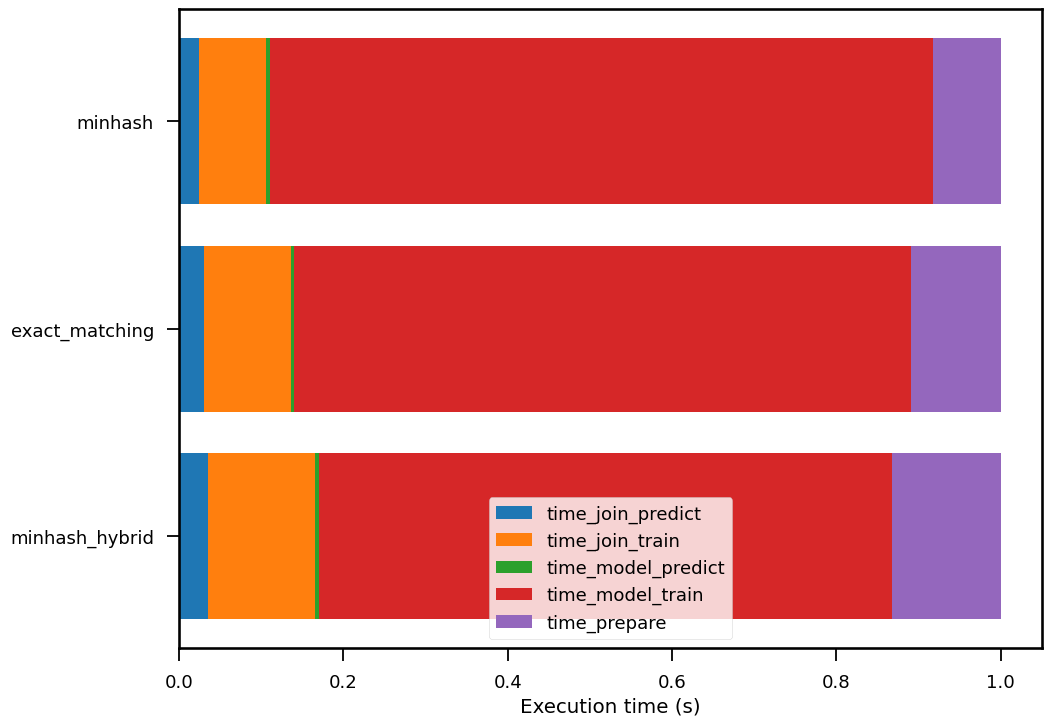

In [15]:
fig, axs = plt.subplots(squeeze=True, layout="constrained")
for idx, d in enumerate(dicts):
    print(d["variable"])
    print(d["csum"])
    p = axs.barh(
        y=d[grouping_variable], width=d["value"], left=d["bottom"], label=d["variable"]
    )
    # axs.bar_label(p,)
axs.legend()
axs.set_xlabel("Execution time (s)")
# fig.savefig(f"images/time_spent_{chosen_model}.png")

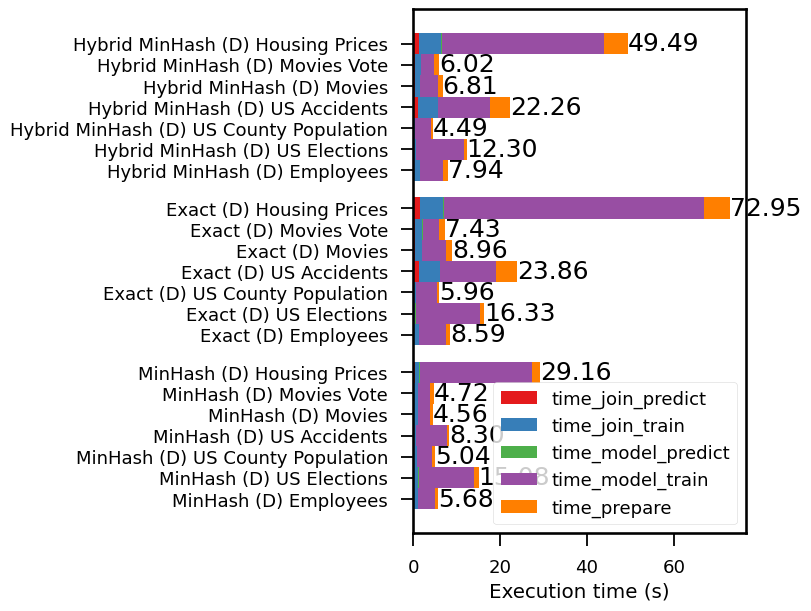

In [16]:
plotting.prepare_grouped_stacked_barplot_time(df_raw, "jd_method", "base_table")

## Comparing with query times

In [61]:
df_query = pl.read_csv("results/query_logging.txt")

In [62]:
(
    df_query.filter(pl.col("data_lake_version") == "wordnet_full")
    .drop("query_column", "step", "time_create", "time_save")
    .group_by("index_name")
    .agg(
        pl.col("time_load").mean(),
        pl.col("time_query").mean(),
    )
)

index_name,time_load,time_query
str,f64,f64
"""exact_matching""",0.032487,0.028169
"""minhash_hybrid""",60.798391,394.429869
"""minhash""",62.971645,1.563113


In [63]:
df_index = pl.read_csv("results/index_logging.txt")

In [64]:
df_index.filter(pl.col("data_lake_version") == "wordnet_full").group_by("index_name","base_table").agg(
        pl.col("time_creation").mean(),
        pl.col("time_save").mean(),
    )
    

index_name,base_table,time_creation,time_save
str,str,f64,f64
"""exact_matching""","""us_county_population-yadl-depleted""",691.827129,0.102967
"""exact_matching""","""movies-yadl-depleted""",814.606058,0.104544
"""exact_matching""","""us_elections-yadl-depleted""",722.628015,0.107629
"""exact_matching""","""us_accidents-yadl-depleted""",684.948381,0.115487
"""exact_matching""","""housing_prices-yadl-depleted""",672.200633,0.103474
"""minhash""",null,2777.567594,144.590746
"""exact_matching""","""company_employees-yadl-depleted""",708.902813,0.15345
"""exact_matching""","""movies_vote-yadl-depleted""",724.229832,0.1210185


In [65]:
d_in = (df_index.filter(pl.col("data_lake_version") == "wordnet_full").group_by("index_name","base_table")
    .agg(
        pl.col("time_creation").mean(),
        pl.col("time_save").mean(),
    )
    .group_by("index_name")
    .agg(
        pl.col("time_creation").sum(),
        pl.col("time_save").sum(),
    )
)
d_in = d_in.vstack(d_in.filter(pl.col("index_name") == "minhash").with_columns(pl.col("index_name").replace("minhash", "minhash_hybrid"))).with_columns(pl.sum_horizontal(cs.numeric()).alias("total_create"))


In [22]:
grouping_variable = "jd_method"
res_pipeline = (
    df_raw.group_by(grouping_variable)
    .agg(
        # pl.col("time_fit").mean(),
        # pl.col("time_predict").mean(),
        # pl.col("time_run").mean(),
        pl.col("time_prepare").mean(),
        pl.col("time_model_train").mean(),
        pl.col("time_join_train").mean(),
        pl.col("time_model_predict").mean(),
        pl.col("time_join_predict").mean(),
    )
    .with_columns(pl.sum_horizontal(cs.numeric()).alias("total_pipeline"))
)

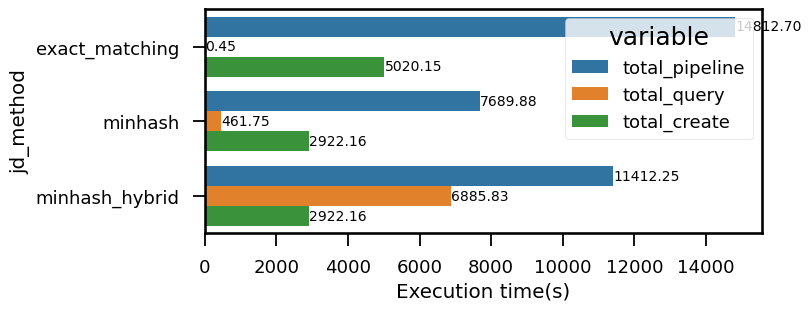

In [81]:
grouping_variable = "jd_method"
res_pipeline = (
    df_raw.group_by(grouping_variable)
    .agg(
        pl.col("time_run").sum(),
    )
    .with_columns(pl.sum_horizontal(cs.numeric()).alias("total_pipeline"))
)
fres = res_pipeline.join(
    (
        df_query.filter(pl.col("data_lake_version") == "wordnet_full")
        .drop("query_column", "step", "time_create", "time_save")
        .group_by("index_name")
        .agg(
            pl.col("time_load").sum(),
            pl.col("time_query").sum(),
        )
        .with_columns(pl.sum_horizontal(cs.numeric()).alias("total_query"))
    ),
    left_on="jd_method",
    right_on="index_name",
).join(
    d_in,
    left_on="jd_method",
    right_on="index_name",
).select(
    pl.col("jd_method", "total_pipeline", "total_query", "total_create")
).melt(id_vars=["jd_method"])

fig, ax = plt.subplots(squeeze=True, figsize=(8,3), layout="constrained")

sns.barplot(data=fres.to_pandas(), x="value", y="jd_method", hue="variable", ax=ax)
ax.set_xlabel("Execution time(s)")
ax.bar_label(ax.containers[0], fontsize=10,fmt="{:.2f}")
ax.bar_label(ax.containers[1], fontsize=10,fmt="{:.2f}")
ax.bar_label(ax.containers[2], fontsize=10,fmt="{:.2f}")
fig.savefig("images/overall_time_spent.pdf")
fig.savefig("images/overall_time_spent.png")

# Memory footprint

In [24]:
exp_path = "results/logs/0363-mp1a3by4"
df_raw = read_logs(exp_name=None, exp_path=exp_path)

In [25]:
df_mem = df_raw.select(
    pl.col("estimator"),
    pl.col("chosen_model"),
    pl.col("peak_fit"),
    pl.col("peak_predict"),
    # pl.col("peak_test"),
).melt(id_vars=["estimator", "chosen_model"])

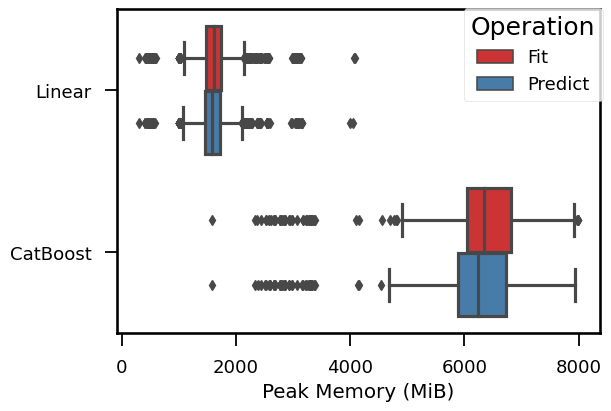

In [26]:
mapping = {"peak_fit": "Fit", "peak_predict": "Predict"}
fig, ax = plt.subplots(figsize=(6, 4), layout="constrained")
sns.boxplot(
    data=df_mem.to_pandas(),
    x="value",
    y="chosen_model",
    hue="variable",
    palette="Set1",
    ax=ax,
    dodge=0.15,
)
ax.set_xlabel("Peak Memory (MiB)")
ax.set_ylabel(None)
# ax.set_ylabel("Estimator")
h, l = ax.get_legend_handles_labels()
ax.get_legend().remove()
ax.set_yticklabels(
    [LABEL_MAPPING["chosen_model"][x.get_text()] for x in ax.get_yticklabels()]
)
fig.legend(h, [mapping[x] for x in l], title="Operation", loc="upper right")
fig.savefig("images/memory_usage.pdf")

For reference: using barplots rather than boxplots. 

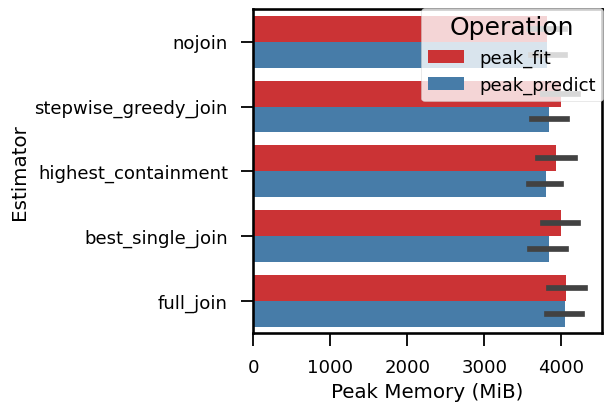

In [27]:
fig, ax = plt.subplots(figsize=(6, 4), layout="constrained")
sns.barplot(
    data=df_mem.to_pandas(),
    x="value",
    y="estimator",
    hue="variable",
    palette="Set1",
    ax=ax,
    dodge=0.15,
)
ax.set_xlabel("Peak Memory (MiB)")
ax.set_ylabel("Estimator")
h, l = ax.get_legend_handles_labels()
ax.get_legend().remove()
# ax.set_xscale("log")
fig.legend(h, l, title="Operation", loc="upper right")
# fig.savefig("images/memory_usage.pdf")

For reference: here I am plotting boxplots for the model and estimator. The difference between ML models (averaging over estimators) is far more noticeable than the
difference between estimators (averaging over ML models).

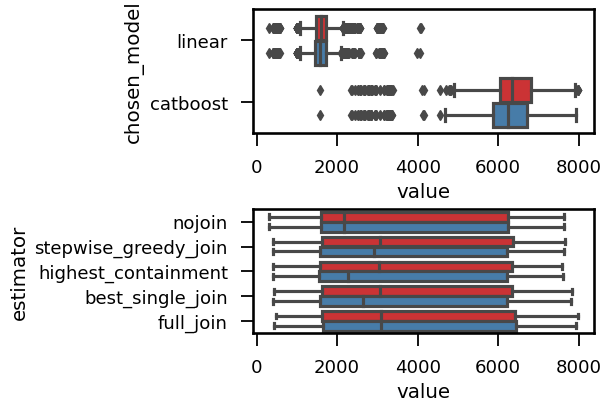

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4), layout="constrained")
sns.boxplot(
    data=df_mem.to_pandas(),
    x="value",
    y="chosen_model",
    hue="variable",
    palette="Set1",
    dodge=0.15,
    ax=ax[0],
)
sns.boxplot(
    data=df_mem.to_pandas(),
    x="value",
    y="estimator",
    hue="variable",
    palette="Set1",
    dodge=0.15,
    ax=ax[1],
)
# ax.set_xlabel("Peak Memory (MiB)")
# ax.set_ylabel("Estimator")
# h, l = ax.get_legend_handles_labels()
ax[0].get_legend().remove()
ax[1].get_legend().remove()
# fig.legend(h, l, title="Operation", loc="upper right")
# fig.savefig("images/memory_usage.pdf")

For reference, here I am splitting by ML model to highlight the difference between estimators. The x-axis is not shared. Once again, the difference is mostly 
due to the ML model, rather than the estimator. 

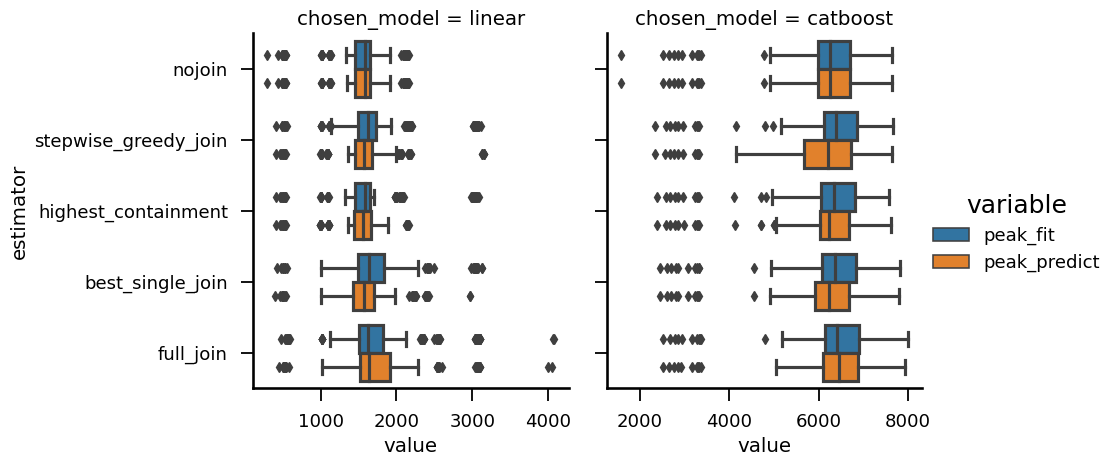

In [29]:
sns.catplot(
    data=df_mem.to_pandas(),
    x="value",
    y="estimator",
    col="chosen_model",
    hue="variable",
    kind="box",
    sharex=False,
)